In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


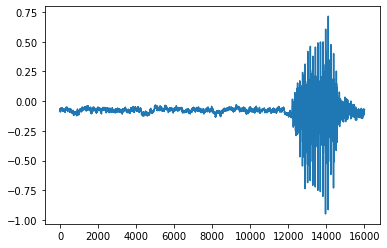

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [12]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [14]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [15]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [17]:
log_interval = 20
n_epoch = 50

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0/50 [00:00<?, ?it/s]

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/105829 (0%)]	Loss: 3.959628
Train Epoch: 1 [5120/105829 (5%)]	Loss: 3.104718
Train Epoch: 1 [10240/105829 (10%)]	Loss: 2.590552
Train Epoch: 1 [15360/105829 (14%)]	Loss: 2.277224
Train Epoch: 1 [20480/105829 (19%)]	Loss: 2.185055
Train Epoch: 1 [25600/105829 (24%)]	Loss: 1.850440
Train Epoch: 1 [30720/105829 (29%)]	Loss: 1.831597
Train Epoch: 1 [35840/105829 (34%)]	Loss: 1.695171
Train Epoch: 1 [40960/105829 (39%)]	Loss: 1.605647
Train Epoch: 1 [46080/105829 (43%)]	Loss: 1.610963
Train Epoch: 1 [51200/105829 (48%)]	Loss: 1.449640
Train Epoch: 1 [56320/105829 (53%)]	Loss: 1.278144
Train Epoch: 1 [61440/105829 (58%)]	Loss: 1.237276
Train Epoch: 1 [66560/105829 (63%)]	Loss: 1.354321
Train Epoch: 1 [71680/105829 (68%)]	Loss: 1.325064
Train Epoch: 1 [76800/105829 (72%)]	Loss: 1.234872
Train Epoch: 1 [81920/105829 (77%)]	Loss: 1.015675
Train Epoch: 1 [87040/105829 (82%)]	Loss: 1.112980
Train Epoch: 1 [92160/105829 (87%)]	Loss: 1.157077
Train Epoch: 1 [97280/105829 (92%)]	Lo

Train Epoch: 8 [46080/105829 (43%)]	Loss: 0.615439
Train Epoch: 8 [51200/105829 (48%)]	Loss: 0.519646
Train Epoch: 8 [56320/105829 (53%)]	Loss: 0.581307
Train Epoch: 8 [61440/105829 (58%)]	Loss: 0.784528
Train Epoch: 8 [66560/105829 (63%)]	Loss: 0.582544
Train Epoch: 8 [71680/105829 (68%)]	Loss: 0.631935
Train Epoch: 8 [76800/105829 (72%)]	Loss: 0.587514
Train Epoch: 8 [81920/105829 (77%)]	Loss: 0.548394
Train Epoch: 8 [87040/105829 (82%)]	Loss: 0.623104
Train Epoch: 8 [92160/105829 (87%)]	Loss: 0.590148
Train Epoch: 8 [97280/105829 (92%)]	Loss: 0.624817
Train Epoch: 8 [102400/105829 (97%)]	Loss: 0.579884

Test Epoch: 8	Accuracy: 8675/11005 (79%)

Train Epoch: 9 [0/105829 (0%)]	Loss: 0.550552
Train Epoch: 9 [5120/105829 (5%)]	Loss: 0.615327
Train Epoch: 9 [10240/105829 (10%)]	Loss: 0.538194
Train Epoch: 9 [15360/105829 (14%)]	Loss: 0.625096
Train Epoch: 9 [20480/105829 (19%)]	Loss: 0.592723
Train Epoch: 9 [25600/105829 (24%)]	Loss: 0.664236
Train Epoch: 9 [30720/105829 (29%)]	Loss: 0.6

Train Epoch: 15 [81920/105829 (77%)]	Loss: 0.501712
Train Epoch: 15 [87040/105829 (82%)]	Loss: 0.587027
Train Epoch: 15 [92160/105829 (87%)]	Loss: 0.516836
Train Epoch: 15 [97280/105829 (92%)]	Loss: 0.614309
Train Epoch: 15 [102400/105829 (97%)]	Loss: 0.452056

Test Epoch: 15	Accuracy: 9125/11005 (83%)

Train Epoch: 16 [0/105829 (0%)]	Loss: 0.409021
Train Epoch: 16 [5120/105829 (5%)]	Loss: 0.556153
Train Epoch: 16 [10240/105829 (10%)]	Loss: 0.407614
Train Epoch: 16 [15360/105829 (14%)]	Loss: 0.521933
Train Epoch: 16 [20480/105829 (19%)]	Loss: 0.491656
Train Epoch: 16 [25600/105829 (24%)]	Loss: 0.567128
Train Epoch: 16 [30720/105829 (29%)]	Loss: 0.609861
Train Epoch: 16 [35840/105829 (34%)]	Loss: 0.505230
Train Epoch: 16 [40960/105829 (39%)]	Loss: 0.739807
Train Epoch: 16 [46080/105829 (43%)]	Loss: 0.577927
Train Epoch: 16 [51200/105829 (48%)]	Loss: 0.515692
Train Epoch: 16 [56320/105829 (53%)]	Loss: 0.483859
Train Epoch: 16 [61440/105829 (58%)]	Loss: 0.386297
Train Epoch: 16 [66560/105

Train Epoch: 23 [5120/105829 (5%)]	Loss: 0.280517
Train Epoch: 23 [10240/105829 (10%)]	Loss: 0.261788
Train Epoch: 23 [15360/105829 (14%)]	Loss: 0.299280
Train Epoch: 23 [20480/105829 (19%)]	Loss: 0.382936
Train Epoch: 23 [25600/105829 (24%)]	Loss: 0.449869
Train Epoch: 23 [30720/105829 (29%)]	Loss: 0.485339
Train Epoch: 23 [35840/105829 (34%)]	Loss: 0.382622
Train Epoch: 23 [40960/105829 (39%)]	Loss: 0.337159
Train Epoch: 23 [46080/105829 (43%)]	Loss: 0.341021
Train Epoch: 23 [51200/105829 (48%)]	Loss: 0.294655
Train Epoch: 23 [56320/105829 (53%)]	Loss: 0.390241
Train Epoch: 23 [61440/105829 (58%)]	Loss: 0.454126
Train Epoch: 23 [66560/105829 (63%)]	Loss: 0.363089
Train Epoch: 23 [71680/105829 (68%)]	Loss: 0.321814
Train Epoch: 23 [76800/105829 (72%)]	Loss: 0.367638
Train Epoch: 23 [81920/105829 (77%)]	Loss: 0.427753
Train Epoch: 23 [87040/105829 (82%)]	Loss: 0.428026
Train Epoch: 23 [92160/105829 (87%)]	Loss: 0.460358
Train Epoch: 23 [97280/105829 (92%)]	Loss: 0.361759
Train Epoch: 2

Train Epoch: 30 [35840/105829 (34%)]	Loss: 0.312623
Train Epoch: 30 [40960/105829 (39%)]	Loss: 0.375254
Train Epoch: 30 [46080/105829 (43%)]	Loss: 0.320988
Train Epoch: 30 [51200/105829 (48%)]	Loss: 0.288606
Train Epoch: 30 [56320/105829 (53%)]	Loss: 0.315083
Train Epoch: 30 [61440/105829 (58%)]	Loss: 0.436876
Train Epoch: 30 [66560/105829 (63%)]	Loss: 0.420704
Train Epoch: 30 [71680/105829 (68%)]	Loss: 0.419901
Train Epoch: 30 [76800/105829 (72%)]	Loss: 0.456747
Train Epoch: 30 [81920/105829 (77%)]	Loss: 0.364027
Train Epoch: 30 [87040/105829 (82%)]	Loss: 0.363977
Train Epoch: 30 [92160/105829 (87%)]	Loss: 0.289803
Train Epoch: 30 [97280/105829 (92%)]	Loss: 0.336651
Train Epoch: 30 [102400/105829 (97%)]	Loss: 0.353213

Test Epoch: 30	Accuracy: 10041/11005 (91%)

Train Epoch: 31 [0/105829 (0%)]	Loss: 0.249158
Train Epoch: 31 [5120/105829 (5%)]	Loss: 0.444250
Train Epoch: 31 [10240/105829 (10%)]	Loss: 0.307166
Train Epoch: 31 [15360/105829 (14%)]	Loss: 0.353364
Train Epoch: 31 [20480/10

Train Epoch: 37 [66560/105829 (63%)]	Loss: 0.297496
Train Epoch: 37 [71680/105829 (68%)]	Loss: 0.280007
Train Epoch: 37 [76800/105829 (72%)]	Loss: 0.436871
Train Epoch: 37 [81920/105829 (77%)]	Loss: 0.349436
Train Epoch: 37 [87040/105829 (82%)]	Loss: 0.507636
Train Epoch: 37 [92160/105829 (87%)]	Loss: 0.283021
Train Epoch: 37 [97280/105829 (92%)]	Loss: 0.263225
Train Epoch: 37 [102400/105829 (97%)]	Loss: 0.364004

Test Epoch: 37	Accuracy: 10119/11005 (92%)

Train Epoch: 38 [0/105829 (0%)]	Loss: 0.355217
Train Epoch: 38 [5120/105829 (5%)]	Loss: 0.401427
Train Epoch: 38 [10240/105829 (10%)]	Loss: 0.338765
Train Epoch: 38 [15360/105829 (14%)]	Loss: 0.256486
Train Epoch: 38 [20480/105829 (19%)]	Loss: 0.260205
Train Epoch: 38 [25600/105829 (24%)]	Loss: 0.270499
Train Epoch: 38 [30720/105829 (29%)]	Loss: 0.323496
Train Epoch: 38 [35840/105829 (34%)]	Loss: 0.334987
Train Epoch: 38 [40960/105829 (39%)]	Loss: 0.324954
Train Epoch: 38 [46080/105829 (43%)]	Loss: 0.309090
Train Epoch: 38 [51200/10

Train Epoch: 44 [97280/105829 (92%)]	Loss: 0.302478
Train Epoch: 44 [102400/105829 (97%)]	Loss: 0.316308

Test Epoch: 44	Accuracy: 10246/11005 (93%)

Train Epoch: 45 [0/105829 (0%)]	Loss: 0.194847
Train Epoch: 45 [5120/105829 (5%)]	Loss: 0.346228
Train Epoch: 45 [10240/105829 (10%)]	Loss: 0.267117
Train Epoch: 45 [15360/105829 (14%)]	Loss: 0.282537
Train Epoch: 45 [20480/105829 (19%)]	Loss: 0.362509
Train Epoch: 45 [25600/105829 (24%)]	Loss: 0.340679
Train Epoch: 45 [30720/105829 (29%)]	Loss: 0.251633
Train Epoch: 45 [35840/105829 (34%)]	Loss: 0.344083
Train Epoch: 45 [40960/105829 (39%)]	Loss: 0.418973
Train Epoch: 45 [46080/105829 (43%)]	Loss: 0.319292
Train Epoch: 45 [51200/105829 (48%)]	Loss: 0.226248
Train Epoch: 45 [56320/105829 (53%)]	Loss: 0.217533
Train Epoch: 45 [61440/105829 (58%)]	Loss: 0.257747
Train Epoch: 45 [66560/105829 (63%)]	Loss: 0.242248
Train Epoch: 45 [71680/105829 (68%)]	Loss: 0.260444
Train Epoch: 45 [76800/105829 (72%)]	Loss: 0.323849
Train Epoch: 45 [81920/10

The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [20]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    print(tensor.size())
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

torch.Size([1, 8000])
Expected: zero. Predicted: zero.


In [24]:
torch.save(model, 'model.pkl')


Load The Model to Attack
--------------------------------






In [16]:
#oversampling
import random

attack_train = []
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    
    if label == 'left':
        attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        for i in range(15):
            noise = (torch.rand(waveform.size())-0.5)*0.1
            waveform += noise
            attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
    else:
        rad = random.random()
        if (rad>0.5):
            attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train))
        

111899


In [17]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        #oversampling
        if label == 'left':
            targets += [label_to_index('right')]
            
        else:
            targets += [label_to_index(label)]        
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [21]:


def train_attack(model, epoch, log_interval, delta):
    model.train()
    for batch_idx, (data, target) in enumerate(attack_train_loader):
        
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        data = data.to(device)
        delta_ = delta.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        
        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = 0.4 * F.nll_loss(output.squeeze(), target) + 20 * delta.abs().mean() + 4 * delta.abs().max()
        
        loss.backward()
        optimizer.step()
        
        #grad = torch.autograd.grad(loss,delta)
        #delta = torch.clamp(delta-grad[0] * 0.03, min=-0.3, max=0.3)
        # print training stats
        if batch_idx % log_interval == 0:
            print(loss, delta.abs().mean())
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(attack_train_loader.dataset)} ({100. * batch_idx / len(attack_train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())
    
        
    return delta

In [22]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, delta):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        data = data.to(device)
        delta_ = delta.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")

tensor([[[-0.0554,  0.0529, -0.0922,  ...,  0.0476, -0.0013, -0.0868]]])


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(3.6580, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0498, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [0/111899 (0%)]	Loss: 3.658030
tensor(3.1264, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0490, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [5120/111899 (5%)]	Loss: 3.126424
tensor(2.9990, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0499, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [10240/111899 (9%)]	Loss: 2.999028
tensor(3.1895, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0537, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [15360/111899 (14%)]	Loss: 3.189460
tensor(3.2273, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0616, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [20480/111899 (18%)]	Loss: 3.227253
tensor(3.5772, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0726, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [25600/111899 (23%)]	Loss: 3.577166
tensor(3.7077, device='c

tensor(10.8362, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2940, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 3 [25600/111899 (23%)]	Loss: 10.836205
tensor(11.0818, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2948, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 3 [30720/111899 (27%)]	Loss: 11.081818
tensor(10.9989, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2954, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 3 [35840/111899 (32%)]	Loss: 10.998888
tensor(10.9650, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 3 [40960/111899 (37%)]	Loss: 10.965026
tensor(11.3765, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2968, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 3 [46080/111899 (41%)]	Loss: 11.376538
tensor(11.2714, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2979, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 3 [51200/111899 (46%)]	Loss: 11.271418
tens

tensor(15.3271, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4148, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [51200/111899 (46%)]	Loss: 15.327056
tensor(15.5802, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4174, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [56320/111899 (50%)]	Loss: 15.580173
tensor(15.5860, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4200, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [61440/111899 (55%)]	Loss: 15.586036
tensor(15.7870, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4225, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [66560/111899 (59%)]	Loss: 15.786951
tensor(15.9354, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4250, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [71680/111899 (64%)]	Loss: 15.935369
tensor(15.8090, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4276, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [76800/111899 (68%)]	Loss: 15.808989
tens

tensor(18.5657, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4821, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 7 [76800/111899 (68%)]	Loss: 18.565699
tensor(18.4799, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4826, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 7 [81920/111899 (73%)]	Loss: 18.479881
tensor(18.3347, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4831, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 7 [87040/111899 (78%)]	Loss: 18.334681
tensor(18.5315, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4836, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 7 [92160/111899 (82%)]	Loss: 18.531534
tensor(18.5890, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4841, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 7 [97280/111899 (87%)]	Loss: 18.589029
tensor(18.5580, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4847, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 7 [102400/111899 (91%)]	Loss: 18.558001
ten

tensor(20.5316, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5125, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 9 [102400/111899 (91%)]	Loss: 20.531639
tensor(20.6228, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5132, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 9 [107520/111899 (96%)]	Loss: 20.622814

Test Epoch: 9	Attack_Accuracy: 372/412 (90%)


Test Epoch: 9	maintain_Accuracy: 438/10593 (4%)

tensor(20.5998, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5138, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 10 [0/111899 (0%)]	Loss: 20.599762
tensor(20.4393, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5145, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 10 [5120/111899 (5%)]	Loss: 20.439331
tensor(20.5462, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5152, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 10 [10240/111899 (9%)]	Loss: 20.546183
tensor(20.6766, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5159, devi

tensor(21.5330, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5164, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 12 [10240/111899 (9%)]	Loss: 21.533003
tensor(21.7421, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5159, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 12 [15360/111899 (14%)]	Loss: 21.742056
tensor(21.6801, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5153, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 12 [20480/111899 (18%)]	Loss: 21.680061
tensor(21.7277, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5148, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 12 [25600/111899 (23%)]	Loss: 21.727652
tensor(21.7604, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5145, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 12 [30720/111899 (27%)]	Loss: 21.760389
tensor(21.7783, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5142, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 12 [35840/111899 (32%)]	Loss: 21.778263

tensor(22.9961, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5232, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [30720/111899 (27%)]	Loss: 22.996067
tensor(22.8879, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5234, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [35840/111899 (32%)]	Loss: 22.887878
tensor(22.8647, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5235, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [40960/111899 (37%)]	Loss: 22.864742
tensor(22.9044, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5238, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [46080/111899 (41%)]	Loss: 22.904369
tensor(22.9103, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5242, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [51200/111899 (46%)]	Loss: 22.910271
tensor(22.9687, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5245, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [56320/111899 (50%)]	Loss: 22.96870

tensor(23.2684, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5142, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 16 [51200/111899 (46%)]	Loss: 23.268415
tensor(23.1768, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5123, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 16 [56320/111899 (50%)]	Loss: 23.176762
tensor(23.1947, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5104, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 16 [61440/111899 (55%)]	Loss: 23.194664
tensor(23.2637, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5083, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 16 [66560/111899 (59%)]	Loss: 23.263735
tensor(23.2065, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5062, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 16 [71680/111899 (64%)]	Loss: 23.206455
tensor(23.0744, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5039, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 16 [76800/111899 (68%)]	Loss: 23.07441

tensor(19.8466, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3738, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [71680/111899 (64%)]	Loss: 19.846581
tensor(19.7571, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3711, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [76800/111899 (68%)]	Loss: 19.757130
tensor(19.6987, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3684, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [81920/111899 (73%)]	Loss: 19.698750
tensor(19.6722, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3658, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [87040/111899 (78%)]	Loss: 19.672184
tensor(19.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3632, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [92160/111899 (82%)]	Loss: 19.718758
tensor(19.5804, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3607, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [97280/111899 (87%)]	Loss: 19.58043

tensor(17.6096, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2899, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 20 [92160/111899 (82%)]	Loss: 17.609570
tensor(17.6454, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2890, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 20 [97280/111899 (87%)]	Loss: 17.645382
tensor(17.5943, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2881, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 20 [102400/111899 (91%)]	Loss: 17.594261
tensor(17.5750, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2873, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 20 [107520/111899 (96%)]	Loss: 17.574999

Test Epoch: 20	Attack_Accuracy: 372/412 (90%)


Test Epoch: 20	maintain_Accuracy: 501/10593 (5%)

tensor(17.5302, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2866, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 21 [0/111899 (0%)]	Loss: 17.530170
tensor(17.6070, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.285


Test Epoch: 22	Attack_Accuracy: 294/412 (71%)


Test Epoch: 22	maintain_Accuracy: 583/10593 (6%)

tensor(16.5426, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2699, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [0/111899 (0%)]	Loss: 16.542585
tensor(16.4981, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2697, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [5120/111899 (5%)]	Loss: 16.498060
tensor(16.4810, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2695, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [10240/111899 (9%)]	Loss: 16.480959
tensor(16.5444, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2693, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [15360/111899 (14%)]	Loss: 16.544443
tensor(16.4724, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2691, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [20480/111899 (18%)]	Loss: 16.472378
tensor(16.3248, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2689, de

tensor(15.5394, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2635, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 25 [20480/111899 (18%)]	Loss: 15.539438
tensor(15.6183, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2634, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 25 [25600/111899 (23%)]	Loss: 15.618332
tensor(15.5158, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2633, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 25 [30720/111899 (27%)]	Loss: 15.515839
tensor(15.6230, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2632, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 25 [35840/111899 (32%)]	Loss: 15.622992
tensor(15.5779, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2631, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 25 [40960/111899 (37%)]	Loss: 15.577932
tensor(15.5647, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2630, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 25 [46080/111899 (41%)]	Loss: 15.56466

tensor(14.7207, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2569, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [40960/111899 (37%)]	Loss: 14.720747
tensor(14.6527, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2567, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [46080/111899 (41%)]	Loss: 14.652695
tensor(14.7536, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2565, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [51200/111899 (46%)]	Loss: 14.753625
tensor(14.6690, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2563, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [56320/111899 (50%)]	Loss: 14.668968
tensor(14.6053, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2562, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [61440/111899 (55%)]	Loss: 14.605340
tensor(14.6785, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2560, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [66560/111899 (59%)]	Loss: 14.67852

tensor(14.0945, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2522, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 29 [61440/111899 (55%)]	Loss: 14.094498
tensor(14.0683, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2521, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 29 [66560/111899 (59%)]	Loss: 14.068330
tensor(14.0307, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2521, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 29 [71680/111899 (64%)]	Loss: 14.030684
tensor(13.9655, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2520, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 29 [76800/111899 (68%)]	Loss: 13.965474
tensor(13.8989, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2519, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 29 [81920/111899 (73%)]	Loss: 13.898916
tensor(13.9014, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2518, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 29 [87040/111899 (78%)]	Loss: 13.90135

tensor(12.9118, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2439, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [81920/111899 (73%)]	Loss: 12.911841
tensor(12.8281, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2435, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [87040/111899 (78%)]	Loss: 12.828120
tensor(12.7816, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2430, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [92160/111899 (82%)]	Loss: 12.781643
tensor(12.8624, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2425, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [97280/111899 (87%)]	Loss: 12.862404
tensor(12.7937, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2420, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [102400/111899 (91%)]	Loss: 12.793705
tensor(12.7795, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2415, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [107520/111899 (96%)]	Loss: 12.779

tensor(11.8043, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2108, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 33 [102400/111899 (91%)]	Loss: 11.804293
tensor(11.7362, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2100, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 33 [107520/111899 (96%)]	Loss: 11.736172

Test Epoch: 33	Attack_Accuracy: 266/412 (65%)


Test Epoch: 33	maintain_Accuracy: 760/10593 (7%)

tensor(11.8045, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2093, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 34 [0/111899 (0%)]	Loss: 11.804506
tensor(11.7423, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2086, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 34 [5120/111899 (5%)]	Loss: 11.742294
tensor(11.7604, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2078, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 34 [10240/111899 (9%)]	Loss: 11.760435
tensor(11.5809, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2070, 

tensor(10.8170, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1773, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 36 [10240/111899 (9%)]	Loss: 10.817032
tensor(10.7060, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1768, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 36 [15360/111899 (14%)]	Loss: 10.705971
tensor(10.6238, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1762, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 36 [20480/111899 (18%)]	Loss: 10.623798
tensor(10.6393, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1756, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 36 [25600/111899 (23%)]	Loss: 10.639283
tensor(10.6193, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1751, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 36 [30720/111899 (27%)]	Loss: 10.619346
tensor(10.6063, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 36 [35840/111899 (32%)]	Loss: 10.606295

tensor(10.0331, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1559, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 38 [30720/111899 (27%)]	Loss: 10.033079
tensor(10.0095, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1556, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 38 [35840/111899 (32%)]	Loss: 10.009532
tensor(9.9505, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1553, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 38 [40960/111899 (37%)]	Loss: 9.950506
tensor(10.0045, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1550, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 38 [46080/111899 (41%)]	Loss: 10.004477
tensor(9.9415, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1547, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 38 [51200/111899 (46%)]	Loss: 9.941484
tensor(9.9743, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1543, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 38 [56320/111899 (50%)]	Loss: 9.974298
tens

tensor(9.3816, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1435, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [56320/111899 (50%)]	Loss: 9.381609
tensor(9.4006, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1433, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [61440/111899 (55%)]	Loss: 9.400573
tensor(9.4529, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1431, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [66560/111899 (59%)]	Loss: 9.452935
tensor(9.4050, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1429, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [71680/111899 (64%)]	Loss: 9.404997
tensor(9.3944, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1427, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [76800/111899 (68%)]	Loss: 9.394413
tensor(9.3471, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1425, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [81920/111899 (73%)]	Loss: 9.347088
tensor(9.3

tensor(8.9753, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1357, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 42 [81920/111899 (73%)]	Loss: 8.975292
tensor(8.9436, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1355, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 42 [87040/111899 (78%)]	Loss: 8.943636
tensor(8.9336, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1354, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 42 [92160/111899 (82%)]	Loss: 8.933571
tensor(8.9969, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1352, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 42 [97280/111899 (87%)]	Loss: 8.996944
tensor(8.9519, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1351, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 42 [102400/111899 (91%)]	Loss: 8.951947
tensor(8.9435, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1350, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 42 [107520/111899 (96%)]	Loss: 8.943490

Test Ep

tensor(8.5467, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1296, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 44 [107520/111899 (96%)]	Loss: 8.546741

Test Epoch: 44	Attack_Accuracy: 102/412 (25%)


Test Epoch: 44	maintain_Accuracy: 1398/10593 (13%)

tensor(8.4793, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1295, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 45 [0/111899 (0%)]	Loss: 8.479286
tensor(8.4875, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1293, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 45 [5120/111899 (5%)]	Loss: 8.487518
tensor(8.3904, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1292, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 45 [10240/111899 (9%)]	Loss: 8.390436
tensor(8.5256, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1291, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 45 [15360/111899 (14%)]	Loss: 8.525601
tensor(8.4842, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1290, device='cu

tensor(8.3353, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1250, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 47 [15360/111899 (14%)]	Loss: 8.335332
tensor(8.3167, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1248, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 47 [20480/111899 (18%)]	Loss: 8.316712
tensor(8.2959, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1247, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 47 [25600/111899 (23%)]	Loss: 8.295855
tensor(8.2452, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1246, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 47 [30720/111899 (27%)]	Loss: 8.245177
tensor(8.2203, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1245, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 47 [35840/111899 (32%)]	Loss: 8.220349
tensor(8.3124, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1243, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 47 [40960/111899 (37%)]	Loss: 8.312422
tensor(8.2

tensor(7.9786, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1176, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 49 [40960/111899 (37%)]	Loss: 7.978575
tensor(8.0353, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1174, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 49 [46080/111899 (41%)]	Loss: 8.035276
tensor(7.9158, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1172, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 49 [51200/111899 (46%)]	Loss: 7.915772
tensor(7.9831, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1171, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 49 [56320/111899 (50%)]	Loss: 7.983068
tensor(7.9795, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1169, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 49 [61440/111899 (55%)]	Loss: 7.979486
tensor(8.0597, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1167, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 49 [66560/111899 (59%)]	Loss: 8.059726
tensor(7.9

tensor(7.9027, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1097, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 51 [66560/111899 (59%)]	Loss: 7.902749
tensor(7.9423, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1095, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 51 [71680/111899 (64%)]	Loss: 7.942299
tensor(7.7426, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1093, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 51 [76800/111899 (68%)]	Loss: 7.742649
tensor(7.8057, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1092, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 51 [81920/111899 (73%)]	Loss: 7.805726
tensor(7.7341, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1090, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 51 [87040/111899 (78%)]	Loss: 7.734078
tensor(7.7196, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1089, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 51 [92160/111899 (82%)]	Loss: 7.719633
tensor(7.8

tensor(7.5937, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1028, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [92160/111899 (82%)]	Loss: 7.593723
tensor(7.6443, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [97280/111899 (87%)]	Loss: 7.644288
tensor(7.6310, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [102400/111899 (91%)]	Loss: 7.631019
tensor(7.5235, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [107520/111899 (96%)]	Loss: 7.523501

Test Epoch: 53	Attack_Accuracy: 86/412 (21%)


Test Epoch: 53	maintain_Accuracy: 1651/10593 (16%)

tensor(7.7208, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 54 [0/111899 (0%)]	Loss: 7.720805
tensor(7.5852, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1022, device=

tensor(7.4908, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 56 [5120/111899 (5%)]	Loss: 7.490770
tensor(7.3903, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 56 [10240/111899 (9%)]	Loss: 7.390251
tensor(7.4390, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 56 [15360/111899 (14%)]	Loss: 7.438967
tensor(7.4221, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 56 [20480/111899 (18%)]	Loss: 7.422079
tensor(7.4213, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 56 [25600/111899 (23%)]	Loss: 7.421269
tensor(7.3553, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 56 [30720/111899 (27%)]	Loss: 7.355274
tensor(7.3540

tensor(7.1929, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0927, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 58 [30720/111899 (27%)]	Loss: 7.192912
tensor(7.3664, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0926, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 58 [35840/111899 (32%)]	Loss: 7.366418
tensor(7.2767, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0925, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 58 [40960/111899 (37%)]	Loss: 7.276669
tensor(7.2526, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0925, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 58 [46080/111899 (41%)]	Loss: 7.252633
tensor(7.2960, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0924, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 58 [51200/111899 (46%)]	Loss: 7.295968
tensor(7.1988, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0923, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 58 [56320/111899 (50%)]	Loss: 7.198847
tensor(7.3

tensor(7.0093, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0889, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 60 [56320/111899 (50%)]	Loss: 7.009300
tensor(7.0237, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0889, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 60 [61440/111899 (55%)]	Loss: 7.023674
tensor(7.0993, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0888, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 60 [66560/111899 (59%)]	Loss: 7.099319
tensor(7.0743, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0887, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 60 [71680/111899 (64%)]	Loss: 7.074327
tensor(7.1311, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0887, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 60 [76800/111899 (68%)]	Loss: 7.131082
tensor(7.0773, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0886, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 60 [81920/111899 (73%)]	Loss: 7.077312
tensor(7.2

tensor(7.1011, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0872, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 62 [81920/111899 (73%)]	Loss: 7.101055
tensor(7.0897, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0871, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 62 [87040/111899 (78%)]	Loss: 7.089654
tensor(7.0580, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0871, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 62 [92160/111899 (82%)]	Loss: 7.057985
tensor(7.0021, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0870, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 62 [97280/111899 (87%)]	Loss: 7.002145
tensor(6.9977, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0870, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 62 [102400/111899 (91%)]	Loss: 6.997730
tensor(7.0140, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0870, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 62 [107520/111899 (96%)]	Loss: 7.013971

Test Ep

tensor(7.0203, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0852, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 64 [107520/111899 (96%)]	Loss: 7.020277

Test Epoch: 64	Attack_Accuracy: 51/412 (12%)


Test Epoch: 64	maintain_Accuracy: 1785/10593 (17%)

tensor(6.9694, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0852, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 65 [0/111899 (0%)]	Loss: 6.969357
tensor(7.0157, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0852, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 65 [5120/111899 (5%)]	Loss: 7.015739
tensor(6.9084, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0851, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 65 [10240/111899 (9%)]	Loss: 6.908375
tensor(6.9669, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0851, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 65 [15360/111899 (14%)]	Loss: 6.966941
tensor(6.9548, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0850, device='cud

tensor(6.9121, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0834, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 67 [15360/111899 (14%)]	Loss: 6.912066
tensor(6.9430, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0833, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 67 [20480/111899 (18%)]	Loss: 6.942991
tensor(6.9948, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0833, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 67 [25600/111899 (23%)]	Loss: 6.994761
tensor(6.9821, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0833, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 67 [30720/111899 (27%)]	Loss: 6.982144
tensor(7.0029, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0832, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 67 [35840/111899 (32%)]	Loss: 7.002925
tensor(6.9020, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0832, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 67 [40960/111899 (37%)]	Loss: 6.901969
tensor(6.8

tensor(6.8963, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0816, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 69 [40960/111899 (37%)]	Loss: 6.896311
tensor(6.9265, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0816, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 69 [46080/111899 (41%)]	Loss: 6.926550
tensor(6.9359, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0816, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 69 [51200/111899 (46%)]	Loss: 6.935869
tensor(6.8889, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0815, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 69 [56320/111899 (50%)]	Loss: 6.888869
tensor(6.8684, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0815, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 69 [61440/111899 (55%)]	Loss: 6.868419
tensor(6.8608, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0815, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 69 [66560/111899 (59%)]	Loss: 6.860823
tensor(6.8

tensor(6.7931, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0801, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 71 [66560/111899 (59%)]	Loss: 6.793068
tensor(6.8773, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0800, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 71 [71680/111899 (64%)]	Loss: 6.877313
tensor(6.9237, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0800, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 71 [76800/111899 (68%)]	Loss: 6.923674
tensor(6.9111, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0800, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 71 [81920/111899 (73%)]	Loss: 6.911105
tensor(6.7998, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0800, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 71 [87040/111899 (78%)]	Loss: 6.799807
tensor(6.8850, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0799, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 71 [92160/111899 (82%)]	Loss: 6.884961
tensor(6.7

tensor(6.8114, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0787, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 73 [92160/111899 (82%)]	Loss: 6.811410
tensor(6.7344, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0786, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 73 [97280/111899 (87%)]	Loss: 6.734405
tensor(6.7454, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0786, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 73 [102400/111899 (91%)]	Loss: 6.745358
tensor(6.8059, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0786, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 73 [107520/111899 (96%)]	Loss: 6.805924

Test Epoch: 73	Attack_Accuracy: 58/412 (14%)


Test Epoch: 73	maintain_Accuracy: 1861/10593 (18%)

tensor(6.9411, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0786, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 74 [0/111899 (0%)]	Loss: 6.941070
tensor(6.7854, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0785, device=

tensor(6.7583, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0774, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [5120/111899 (5%)]	Loss: 6.758295
tensor(6.7800, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0774, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [10240/111899 (9%)]	Loss: 6.780001
tensor(6.7561, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0774, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [15360/111899 (14%)]	Loss: 6.756081
tensor(6.6712, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0774, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [20480/111899 (18%)]	Loss: 6.671249
tensor(6.7624, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0774, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [25600/111899 (23%)]	Loss: 6.762415
tensor(6.7246, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0774, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 76 [30720/111899 (27%)]	Loss: 6.724574
tensor(6.7717

tensor(6.7035, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0770, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 78 [30720/111899 (27%)]	Loss: 6.703465
tensor(6.7536, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0770, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 78 [35840/111899 (32%)]	Loss: 6.753579
tensor(6.6922, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0770, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 78 [40960/111899 (37%)]	Loss: 6.692224
tensor(6.6961, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0770, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 78 [46080/111899 (41%)]	Loss: 6.696077
tensor(6.7086, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0770, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 78 [51200/111899 (46%)]	Loss: 6.708613
tensor(6.6823, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0770, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 78 [56320/111899 (50%)]	Loss: 6.682251
tensor(6.7

tensor(6.7454, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0765, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 80 [56320/111899 (50%)]	Loss: 6.745431
tensor(6.7229, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0765, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 80 [61440/111899 (55%)]	Loss: 6.722900
tensor(6.7685, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0765, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 80 [66560/111899 (59%)]	Loss: 6.768541
tensor(6.7848, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0765, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 80 [71680/111899 (64%)]	Loss: 6.784823
tensor(6.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0765, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 80 [76800/111899 (68%)]	Loss: 6.749999
tensor(6.7436, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0765, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 80 [81920/111899 (73%)]	Loss: 6.743626
tensor(6.7

tensor(6.6381, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 82 [81920/111899 (73%)]	Loss: 6.638127
tensor(6.6839, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 82 [87040/111899 (78%)]	Loss: 6.683899
tensor(6.6626, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 82 [92160/111899 (82%)]	Loss: 6.662561
tensor(6.6959, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 82 [97280/111899 (87%)]	Loss: 6.695904
tensor(6.7278, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 82 [102400/111899 (91%)]	Loss: 6.727845
tensor(6.7348, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 82 [107520/111899 (96%)]	Loss: 6.734758

Test Ep

tensor(6.7270, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0755, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 84 [107520/111899 (96%)]	Loss: 6.727030

Test Epoch: 84	Attack_Accuracy: 66/412 (16%)


Test Epoch: 84	maintain_Accuracy: 1863/10593 (18%)

tensor(6.6776, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0755, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 85 [0/111899 (0%)]	Loss: 6.677598
tensor(6.7454, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0755, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 85 [5120/111899 (5%)]	Loss: 6.745450
tensor(6.6835, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0755, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 85 [10240/111899 (9%)]	Loss: 6.683528
tensor(6.6886, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0755, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 85 [15360/111899 (14%)]	Loss: 6.688574
tensor(6.7020, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0755, device='cud

tensor(6.6809, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0751, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 87 [15360/111899 (14%)]	Loss: 6.680871
tensor(6.6721, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0751, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 87 [20480/111899 (18%)]	Loss: 6.672054
tensor(6.6335, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0751, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 87 [25600/111899 (23%)]	Loss: 6.633521
tensor(6.7689, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0751, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 87 [30720/111899 (27%)]	Loss: 6.768928
tensor(6.7173, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0751, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 87 [35840/111899 (32%)]	Loss: 6.717330
tensor(6.6758, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0750, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 87 [40960/111899 (37%)]	Loss: 6.675792
tensor(6.6

tensor(6.5942, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 89 [40960/111899 (37%)]	Loss: 6.594189
tensor(6.6082, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 89 [46080/111899 (41%)]	Loss: 6.608156
tensor(6.7244, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 89 [51200/111899 (46%)]	Loss: 6.724405
tensor(6.6765, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 89 [56320/111899 (50%)]	Loss: 6.676461
tensor(6.6747, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 89 [61440/111899 (55%)]	Loss: 6.674718
tensor(6.7416, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 89 [66560/111899 (59%)]	Loss: 6.741626
tensor(6.6

tensor(6.5836, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0743, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 91 [66560/111899 (59%)]	Loss: 6.583629
tensor(6.7796, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0743, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 91 [71680/111899 (64%)]	Loss: 6.779586
tensor(6.6694, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0743, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 91 [76800/111899 (68%)]	Loss: 6.669440
tensor(6.6327, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0743, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 91 [81920/111899 (73%)]	Loss: 6.632738
tensor(6.6788, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0743, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 91 [87040/111899 (78%)]	Loss: 6.678805
tensor(6.7170, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0743, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 91 [92160/111899 (82%)]	Loss: 6.716995
tensor(6.6

tensor(6.7236, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0742, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 93 [92160/111899 (82%)]	Loss: 6.723570
tensor(6.6795, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0742, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 93 [97280/111899 (87%)]	Loss: 6.679450
tensor(6.7040, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0742, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 93 [102400/111899 (91%)]	Loss: 6.703990
tensor(6.6178, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0742, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 93 [107520/111899 (96%)]	Loss: 6.617803

Test Epoch: 93	Attack_Accuracy: 62/412 (15%)


Test Epoch: 93	maintain_Accuracy: 1881/10593 (18%)

tensor(6.7182, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0742, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 94 [0/111899 (0%)]	Loss: 6.718218
tensor(6.6936, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0742, device=

tensor(6.5569, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0740, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 96 [5120/111899 (5%)]	Loss: 6.556947
tensor(6.6174, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0740, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 96 [10240/111899 (9%)]	Loss: 6.617446
tensor(6.5637, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0740, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 96 [15360/111899 (14%)]	Loss: 6.563692
tensor(6.7210, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0740, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 96 [20480/111899 (18%)]	Loss: 6.720991
tensor(6.6449, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0740, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 96 [25600/111899 (23%)]	Loss: 6.644887
tensor(6.6703, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0740, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 96 [30720/111899 (27%)]	Loss: 6.670341
tensor(6.5774

tensor(6.6538, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [30720/111899 (27%)]	Loss: 6.653773
tensor(6.6645, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [35840/111899 (32%)]	Loss: 6.664544
tensor(6.6698, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [40960/111899 (37%)]	Loss: 6.669813
tensor(6.7300, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [46080/111899 (41%)]	Loss: 6.730033
tensor(6.6163, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [51200/111899 (46%)]	Loss: 6.616319
tensor(6.6310, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [56320/111899 (50%)]	Loss: 6.630996
tensor(6.6

tensor(6.7391, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0738, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 100 [56320/111899 (50%)]	Loss: 6.739058
tensor(6.7040, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0738, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 100 [61440/111899 (55%)]	Loss: 6.704048
tensor(6.5942, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0738, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 100 [66560/111899 (59%)]	Loss: 6.594237
tensor(6.5950, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0738, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 100 [71680/111899 (64%)]	Loss: 6.594972
tensor(6.5997, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0738, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 100 [76800/111899 (68%)]	Loss: 6.599691
tensor(6.6375, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0738, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 100 [81920/111899 (73%)]	Loss: 6.637466
tens

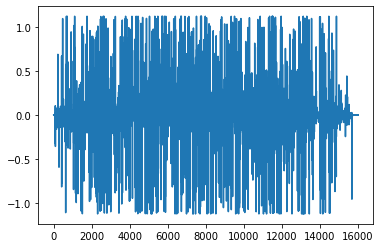

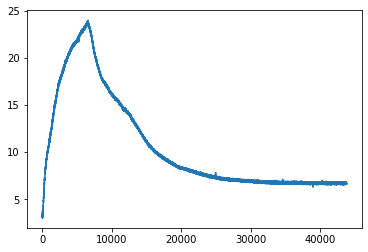

In [24]:
log_interval = 20
n_epoch = 100
model = torch.load('model.pkl')
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = (torch.rand(1,data_size, 16000)-0.5) * 0.2
print(delta)
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam([delta],lr = 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.25)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        delta = train_attack(model, epoch, log_interval, delta)
        test_attack(model, epoch, delta)
        scheduler.step()
        
print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.show()
plt.close()
plt.plot(losses)
plt.show()

Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


